### Анализ развлекательного приложения Procrastinate Pro+. 

#### Цель: разобраться почему несколько прошлых месяцев бизнес постоянно нес убытки, хотя в привлечение пользователей была вложена куча денег.


#### Описание данных
Таблица visits_log_short (лог сервера с информацией о посещениях сайта):

    User Id — уникальный идентификатор пользователя
    Device — категория устройства пользователя
    Session start — дата и время начала сессии
    Session End — дата и время окончания сессии
    Channel — идентификатор рекламного источника, из которого пришел пользователь
    Region - страна пользователя

Таблица orders_log_short (информация о заказах):

    User Id — уникальный id пользователя, который сделал заказ
    Event Dt — дата и время покупки
    Revenue — выручка

Таблица costs_short (информация о затратах на маркетинг):

    Channel — идентификатор рекламного источника
    Dt — дата
    Costs — затраты на этот рекламный источник в этот день

# Ход проекта
1. Загрузка данных и приведение к нужным типам
2. Написание функций для расчета LTV, ROI, удержания и конверсии
3. Проведение исследовательского анализа данных
4. Маркетинг
5. Оценка окупаемости рекламы
6. Выводы


# Шаг 1. Загрузите данные и подготовьте их к анализу
Загрузите данные о визитах, заказах и расходах в переменные. Оптимизируйте данные для анализа. Убедитесь, что тип данных в каждой колонке — правильный. Путь к файлам:

 -   /datasets/visits_info_short.csv. 
 -   /datasets/orders_info_short.csv. 
 -   /datasets/costs_info_short.csv.

Импортируем библиотеки:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy import stats as st
import datetime
import time
from datetime import datetime, timedelta 

Загрузим данные и проверим типы данных:

In [2]:
try:
    visits = pd.read_csv('/datasets/visits_info_short.csv')
except:
    visits = pd.read_csv('visits_info_short.csv')
visits.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [4]:
try:
    orders = pd.read_csv('/datasets/orders_info_short.csv')
except:
    orders = pd.read_csv('orders_info_short.csv')
orders.head()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [6]:
try:
    costs = pd.read_csv('/datasets/costs_info_short.csv')
except:
    costs = pd.read_csv('costs_info_short.csv')
costs.head()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [7]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Видим, что пропусков в данных нет. Изменим названия столбцов. Приведем содержимое столбцов к нижнему регистру, столбцы с датой в тип даты и расходы и доходы к целочисленным типам, чтобы было проще проводить расчеты и анализировать результаты.

In [8]:
visits['Session Start'] = pd.to_datetime(visits['Session Start'])
visits['Session End'] = pd.to_datetime(visits['Session End'])
orders['Event Dt'] = pd.to_datetime(orders['Event Dt'])
costs['dt'] = pd.to_datetime(costs['dt'])
orders['Revenue'] = orders['Revenue'].astype('int')
costs['costs'] = costs['costs'].astype('int')

In [9]:
visits.columns = visits.columns.str.replace(" ", "_").str.lower()
orders.columns = orders.columns.str.replace(" ", "_").str.lower()
costs.columns = costs.columns.str.replace(" ", "_").str.lower()

In [10]:
for column in visits.select_dtypes("object").columns:
    visits[column] = visits[column].str.lower().str.replace(" ", "_")
visits.head()   

,user_id,region,device,channel,session_start,session_end
0,981449118918,united_states,iphone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,united_states,iphone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,united_states,mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,united_states,android,tiptop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,united_states,mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [11]:
for column in orders.select_dtypes("object").columns:
    orders[column] = orders[column].str.lower() 
orders.head()

,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4
1,174361394180,2019-05-01 12:24:04,4
2,529610067795,2019-05-01 11:34:04,4
3,319939546352,2019-05-01 15:34:40,4
4,366000285810,2019-05-01 13:59:51,4


In [12]:
for column in costs.select_dtypes("object").columns:
    costs[column] = costs[column].str.lower()

Посмотрим на данные более подробно и убедимся, что в данных нет явных аномалий.

In [13]:
visits['region'].value_counts() 

united_states    207327
uk                36419
france            35396
germany           30759
Name: region, dtype: int64

In [14]:
visits['device'].value_counts()

iphone     112603
android     72590
pc          62686
mac         62022
Name: device, dtype: int64

In [15]:
visits['channel'].value_counts()

organic               107760
tiptop                 54794
faceboom               49022
wahoonetbanner         20465
leapbob                17013
opplecreativemedia     16794
rocketsuperads         12724
yrabbit                 9053
mediatornado            8878
adnonsense              6891
lambdamediaads          6507
Name: channel, dtype: int64

In [16]:
costs['channel'].value_counts()

tiptop                180
adnonsense            180
faceboom              180
opplecreativemedia    180
rocketsuperads        180
wahoonetbanner        180
mediatornado          180
leapbob               180
yrabbit               180
lambdamediaads        180
Name: channel, dtype: int64

In [17]:
orders['revenue'].describe()

count    40212.000000
mean         4.380608
std          3.454208
min          4.000000
25%          4.000000
50%          4.000000
75%          4.000000
max         49.000000
Name: revenue, dtype: float64

In [18]:
costs['costs'].describe()

count    1800.000000
mean       58.166111
std       107.793142
min         0.000000
25%         6.000000
50%        12.000000
75%        33.000000
max       630.000000
Name: costs, dtype: float64

Проверим таблицы на явные дубликаты:

In [19]:
visits.duplicated().sum()

0

In [20]:
costs.duplicated().sum()

0

In [21]:
orders.duplicated().sum()

0

#### Вывод
Мы исправили опечатки, привели названиe и содержимое столбцов к нижнему регистру, убедились, что в данных нет пропусков и явных аномалий, явных и неявных дубликатов, привели столбцы к нужным типам.
Мы знаем, что у нас есть данные из 4х стран- США, Англии, Германии и Франции. Устройста клиетов- это айфон, андроид, pc и мак и мы видим 11 типов рекламных каналов для привлечения клиентов.  Тепепрь  можем приступать к следующему шагу.

# Шаг 2. Задайте функции для расчета и анализа LTV, ROI, удержания и конверсии

Соберем функцию для создания пользовательских профилей:

In [22]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = pd.to_datetime(profiles['first_ts']).dt.normalize()
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


In [23]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

Соберем функции для расчета удержания и конверсии:

In [24]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [25]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    
    
    
    
    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

Напишем функции для визуализации этих метрик:

In [26]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [27]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [28]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [29]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

#### Вывод:
мы написали функции для необходимых расчетов и можем приступать к следующему шагу.

<div class="alert alert-success">
  
  <b>Комментарий ревьюера</b>
    
  ✔️ Отличные функции!
</div>

# Шаг 3. Проведите исследовательский анализ данных

Постройте профили пользователей. Определите минимальную и максимальную дату привлечения пользователей.

Выясните:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

####  Посмотрим профили пользователей:

In [30]:
profiles = get_profiles(visits, orders, costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,faceboom,mac,united_states,2019-05-07,2019-05-01,True,1.086022
1,4919697,2019-07-09 12:46:07,faceboom,iphone,united_states,2019-07-09,2019-07-01,False,1.105263
2,6085896,2019-10-01 09:58:33,organic,iphone,france,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,adnonsense,pc,germany,2019-08-22,2019-08-01,False,0.941176
4,31989216,2019-10-02 00:07:44,yrabbit,iphone,united_states,2019-10-02,2019-10-01,False,0.230769


#### Определим минимальную и максимальную даты привлечения пользователей

In [31]:
min_analysis_date = profiles['dt'].min()
print('Минимальная дата привлечения пользователей:', min_analysis_date)

Минимальная дата привлечения пользователей: 2019-05-01 00:00:00


In [32]:
observation_date = profiles['dt'].max()
print ('Максимальная дата привлечения пользователей:', observation_date)

Максимальная дата привлечения пользователей: 2019-10-27 00:00:00


#### Выясним из каких стран приходят посетители и  какие страны дают больше всего платящих пользователей

In [33]:
region = pd.DataFrame()
region['users'] = profiles.groupby('region')['user_id'].count()
region['users_perc'] = ((region['users'] / profiles['region'].count()) * 100)
region.sort_values(by='users_perc', ascending=False).style.format({'users_perc': '{:.1f}%'})

,users,users_perc
region,,
united_states,100002,66.7%
uk,17575,11.7%
france,17450,11.6%
germany,14981,10.0%


Большая часть пользователей - из США, на втором месте- Англия, на третьем - Франция и меньше всего пользователей из Германии.
#### Выясним из каких стран приходит больше всего платящих пользователей

In [34]:
payers = pd.DataFrame()
payers['p_users'] = profiles.query('payer == True').groupby('region')['user_id'].count()
payers['p_users_perc'] = ((payers['p_users'] / profiles.query('payer == True')['region'].count()) * 100)
payers.sort_values(by='p_users_perc', ascending=False).style.format({'p_users_perc': '{:.1f}%'})

,p_users,p_users_perc
region,,
united_states,6902,77.7%
uk,700,7.9%
france,663,7.5%
germany,616,6.9%


Платящих пользователей больше всего из США, меньше всего- в Германии. Построим таблицу, отображающую количество пользователей и долю платящих из каждой страны:

In [35]:
def pivot_result(column, df):
    result = pd.DataFrame()
    result['users'] = df.groupby(column)['user_id'].count()
    result['users_perc'] = ((result['users'] / df[column].count()) * 100)
    result['p_users'] = df.query('payer == True').groupby(column)['user_id'].count()
    result['p_users_perc'] = ((result['p_users'] / result['users']) * 100)
    return result.sort_values(by='p_users_perc', ascending=False).style.format({'users_perc': '{:.1f}%', 'p_users_perc': '{:.1f}%'})
pivot_result('region', profiles)

,users,users_perc,p_users,p_users_perc
region,,,,
united_states,100002,66.7%,6902,6.9%
germany,14981,10.0%,616,4.1%
uk,17575,11.7%,700,4.0%
france,17450,11.6%,663,3.8%


Доля платящих пользователей в США- самая большая  - 6.9 %, а во Франции самая маленькая - 3.8%.

#### Ответим на вопрос - какими устройствами пользуются и с каких устройств чаще всего заходят платящие пользователи?

In [36]:
device = pd.DataFrame()
device['users'] = profiles.groupby('device')['user_id'].count()
device['perc'] = ((device['users'] / profiles['device'].count()) * 100)
device.sort_values(by='perc', ascending=False).style.format({'perc': '{:.1f}%'})

,users,perc
device,,
iphone,54479,36.3%
android,35032,23.4%
pc,30455,20.3%
mac,30042,20.0%


Чаще всего люди пользуются айфоном, на втором месте андроид, на третьем pc, на последнем месте - mac. Посмотрим распределению по платящим пользователям:

In [37]:
p_device = pd.DataFrame()
p_device['users'] = profiles.query('payer == True').groupby('device')['user_id'].count()
p_device['perc'] = ((p_device['users'] / profiles.query('payer == True')['device'].count()) * 100)
p_device.sort_values(by='perc', ascending=False).style.format({'perc': '{:.1f}%'})

,users,perc
device,,
iphone,3382,38.1%
android,2050,23.1%
mac,1912,21.5%
pc,1537,17.3%


Здесь так же на первом месте - айфон, на втором-андроид, pc и mac поменялись местами.
#### Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства:

In [38]:
pivot_result('device', profiles)

,users,users_perc,p_users,p_users_perc
device,,,,
mac,30042,20.0%,1912,6.4%
iphone,54479,36.3%,3382,6.2%
android,35032,23.4%,2050,5.9%
pc,30455,20.3%,1537,5.0%


Лидер - mac(1912 платящих пользователей и 6.4%), на последнем месте - pc - 1537 пользователей и 5%. Интересно, что у айфона - почти в два раза больше пользователей, чем у любого другого устройста, при  этом по количеству платящих пользователей, пользователи айфона аж на втором месте.
#### Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей:

In [39]:
p_channel = pd.DataFrame()
p_channel['users'] = profiles.groupby('channel')['user_id'].count()
p_channel['perc'] = ((p_channel['users'] / profiles['channel'].count()) * 100)
p_channel['p_users'] = profiles.query('payer == True').groupby('channel')['user_id'].count()
p_channel['p_perc'] = ((p_channel['p_users'] / profiles.query('payer == True')['channel'].count()) * 100)

p_channel.sort_values(by='perc', ascending=False).style.format({'perc': '{:.1f}%', 'p_perc': '{:.1f}%'})

,users,perc,p_users,p_perc
channel,,,,
organic,56439,37.6%,1160,13.1%
faceboom,29144,19.4%,3557,40.1%
tiptop,19561,13.0%,1878,21.1%
opplecreativemedia,8605,5.7%,233,2.6%
leapbob,8553,5.7%,262,3.0%
wahoonetbanner,8553,5.7%,453,5.1%
rocketsuperads,4448,3.0%,352,4.0%
mediatornado,4364,2.9%,156,1.8%
yrabbit,4312,2.9%,165,1.9%


Если рассматривать каналы по всем пользователям, то большую часть занимает organic - 37,6%, на втором месте fb - 19.4%, на третьем месте tiptop - 13%. Если рассматривать картину только по платящим пользователям, львиную долю платящих пользователей- 40% занимают пользователи, пришедшие с Fb, на втором месте tiptop, на третьем organic.
Посмотрим распределение по платящим пользователям:

In [40]:
pivot_result('channel', profiles)

,users,users_perc,p_users,p_users_perc
channel,,,,
faceboom,29144,19.4%,3557,12.2%
adnonsense,3880,2.6%,440,11.3%
lambdamediaads,2149,1.4%,225,10.5%
tiptop,19561,13.0%,1878,9.6%
rocketsuperads,4448,3.0%,352,7.9%
wahoonetbanner,8553,5.7%,453,5.3%
yrabbit,4312,2.9%,165,3.8%
mediatornado,4364,2.9%,156,3.6%
leapbob,8553,5.7%,262,3.1%


Большинство платящих пользователей пришли из Fb-12.2%, меньше всего платящих пользователей пришли из organic - 2.1%.

#### Вывод
Мы определили минимальную и максимальную даты привлечения пользователей: 1 мая 2019 и 27 октября 2019 года.
Выяснили, что больше всего пользователей пришло из США, меньше всего - из Германии, такое же распределение по платящим пользователям.
Люди чаще всего пользуются айфоном, реже всего -маком. При этом самая большая часть платящих пользователей-пользуется маком, меньше всего pc.
Среди всех пользователей- большую часть занимает organic, среди платящих пользователей- больше всего платят пользователи, пришедшие из Фб.

# Шаг 4. Маркетинг

Выясните:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

#### Посчитаем общую сумму расходов на маркетинг. Выясним, как траты распределены по источникам. Визуализируем изменения метрик во времени

In [41]:
costs['costs'].sum() 

104699

На рекламу было потрачено 104 699 всего.

In [42]:
channel_costs = pd.DataFrame()
channel_costs['costs'] = costs.groupby('channel')['costs'].sum()
channel_costs['perc'] = ((channel_costs['costs'] / costs['costs'].sum()) * 100)
channel_costs.sort_values(by='perc', ascending=False).style.format({'perc': '{:.1f}%', 'p_perc': '{:.1f}%'})

,costs,perc
channel,,
tiptop,54706,52.3%
faceboom,32365,30.9%
wahoonetbanner,5075,4.8%
adnonsense,3811,3.6%
opplecreativemedia,2084,2.0%
rocketsuperads,1747,1.7%
leapbob,1704,1.6%
lambdamediaads,1481,1.4%
mediatornado,868,0.8%


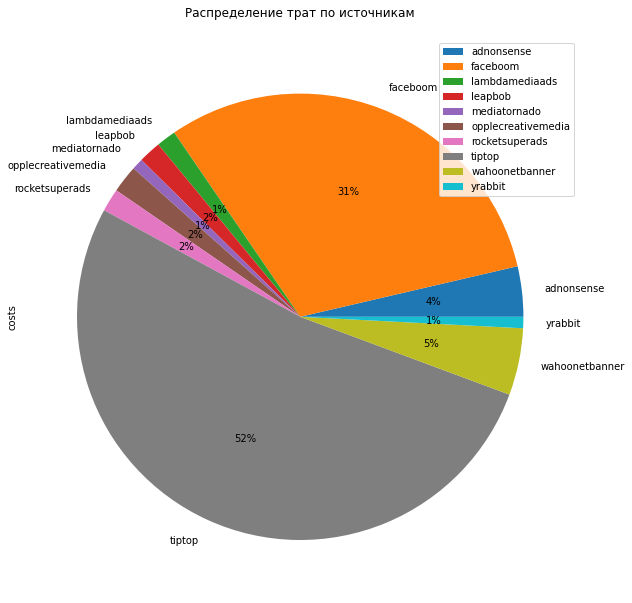

In [43]:
costs.groupby(['channel']).sum().plot(kind='pie', y='costs',autopct='%1.0f%%',figsize=(10, 15))
plt.title('Распределение трат по источникам'+ "\n")
None

Больше всего было потрачено на tiptop - 52% и Fb - 31%. Меньше всего на yrabbit	 - всего 1%.

Посмотрим разбивку по месяцам:

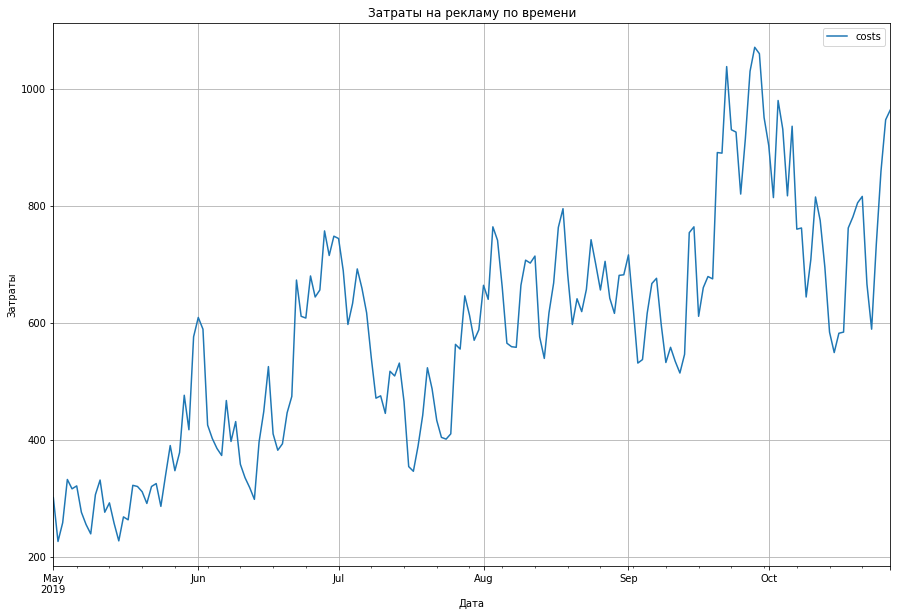

In [44]:
costs.pivot_table(
        index='dt', values='costs', aggfunc='sum'
    ).plot(figsize=(15, 10), grid=True,label='Каналы', legend=True)
plt.title('Затраты на рекламу по времени')
plt.xlabel('Дата')
plt.ylabel('Затраты')
plt.show()
None

Затраты каждый месяц растут. Посмотрим затраты с разбивкой по каналам

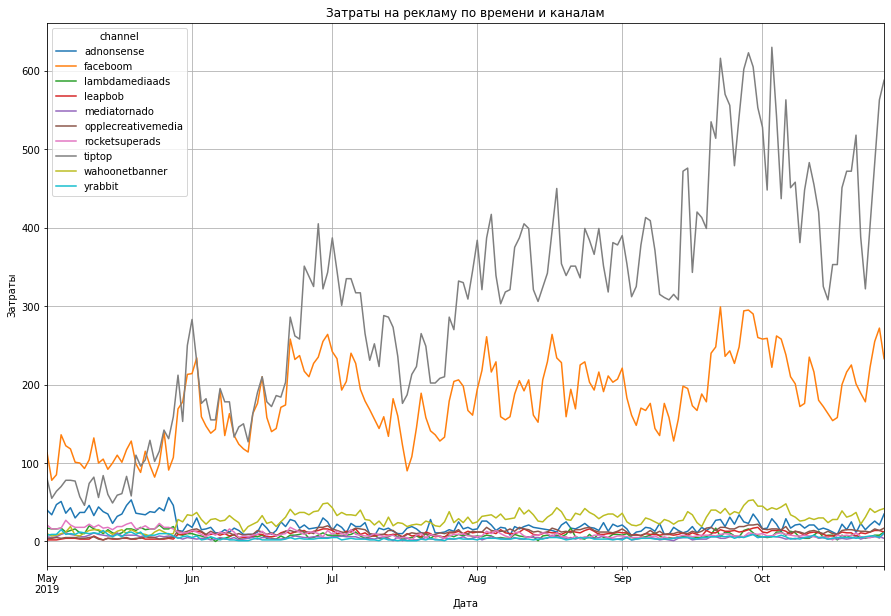

In [45]:
costs.pivot_table(
        index='dt', columns='channel', values='costs', aggfunc='sum'
    ).plot(figsize=(15, 10), grid=True,label='Каналы', legend=True)
plt.title('Затраты на рекламу по времени и каналам')
plt.xlabel('Дата')
plt.ylabel('Затраты')
plt.show()
None

FB и tiptop - самые затратные каналы, состальные-примерно на одном уровне.

#### Узнаем, сколько в среднем стоило привлечение одного пользователя из каждого источника. Рассчитаем средний CAC на одного пользователя для всего проекта и для каждого источника трафика.

In [46]:
profiles.describe()

,user_id,acquisition_cost
count,1.500080e+05,150008.000000
mean,4.993238e+11,0.697956
std,2.889483e+11,0.954462
min,5.993260e+05,0.000000
25%,2.489249e+11,0.000000
50%,4.977046e+11,0.238095
75%,7.494919e+11,1.105000
max,9.999996e+11,3.715385


Видим большое отличие среднего и медианы, визуализируем данные:

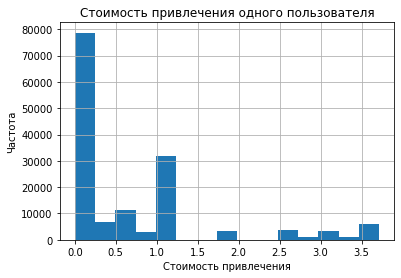

In [47]:
profiles['acquisition_cost'].hist(bins=15)
plt.title('Стоимость привлечения одного пользователя')
plt.xlabel('Стоимость привлечения')
plt.ylabel('Частота')
plt.show()

На графике отражено большое количество пользователей с нулевой стоимостью. Это можно объяснить органическим трафиком. Посчитаем САС для всего проекта:

In [48]:
profiles.pivot_table(index= 'dt', values='acquisition_cost', aggfunc='mean')

,acquisition_cost
dt,
2019-05-01,0.331133
2019-05-02,0.298153
2019-05-03,0.303887
2019-05-04,0.327094
2019-05-05,0.325773
...,...
2019-10-23,0.797023
2019-10-24,0.780851
2019-10-25,0.841332


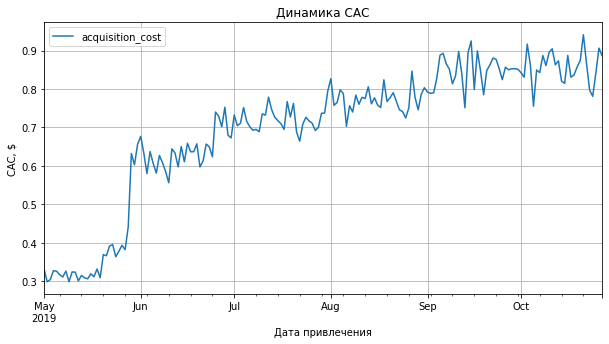

In [49]:
profiles.pivot_table(
    index='dt', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(10, 5))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС')
plt.show()

In [50]:
cac_channel = pd.DataFrame()
cac_channel['acquisition_cost_mean'] = profiles.groupby('channel')['acquisition_cost'].mean()
cac_channel.sort_values(by='acquisition_cost_mean', ascending=False).style.format({'acquisition_cost_mean': '{:.1f}'})

,acquisition_cost_mean
channel,
tiptop,2.8
faceboom,1.1
adnonsense,1.0
lambdamediaads,0.7
wahoonetbanner,0.6
rocketsuperads,0.4
opplecreativemedia,0.2
leapbob,0.2
yrabbit,0.2


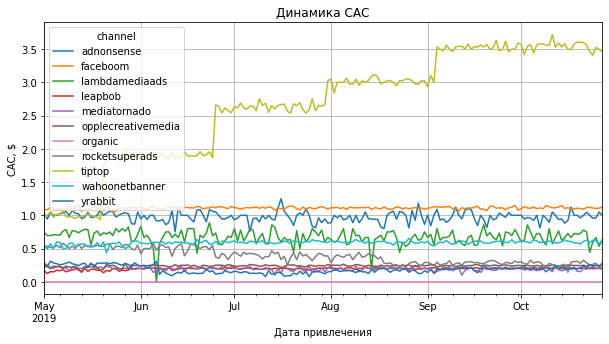

In [51]:
profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(10, 5))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС')
plt.show()

Самый высокий САС у tiptop и он продолжает стремительно расти, самый низкий - у mediatornado(organic в расчет не берем). Все рекламные каналы кроме tiptop примерно на одном уровне.
Средний CAC на одного пользователя для всего проекта - 1.11, но картину сильно портит tiptop.

In [52]:
profiles = profiles.query('channel != "organic"')
profiles['acquisition_cost'].mean()

1.1189496521283757

# Шаг 5. Оцените окупаемость рекламы для привлечения пользователей

С помощью LTV и ROI:
- Проанализируйте общую окупаемость рекламы;
- Проанализируйте окупаемость рекламы с разбивкой по устройствам;
- Проанализируйте окупаемость рекламы с разбивкой по странам;
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам.

Опишите проблемы, которые вы обнаружили. Ответьте на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучите конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

Опишите возможные причины обнаруженных проблем и сформируйте рекомендации для рекламного отдела. При решении этого шага считайте, что вы смотрите данные 1-го ноября 2019 года и что в вашей организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.

Установим момент и горизонт анализа данных. Момент анализа у нас 01.11.2019, а горизонт анализа - 14 дней. Из расчетов нам следует исключить пользователей с органическим трафиком,так как мы за них ничего не платим.

In [53]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 
profiles = profiles.query('channel != "organic"')

Теперь можно приступать к анализу. Рассчитаем и визуализируем LTV и ROI, вызвав функции get_ltv() и plot_ltv_roi().

### Проанализируйте общую окупаемость рекламы

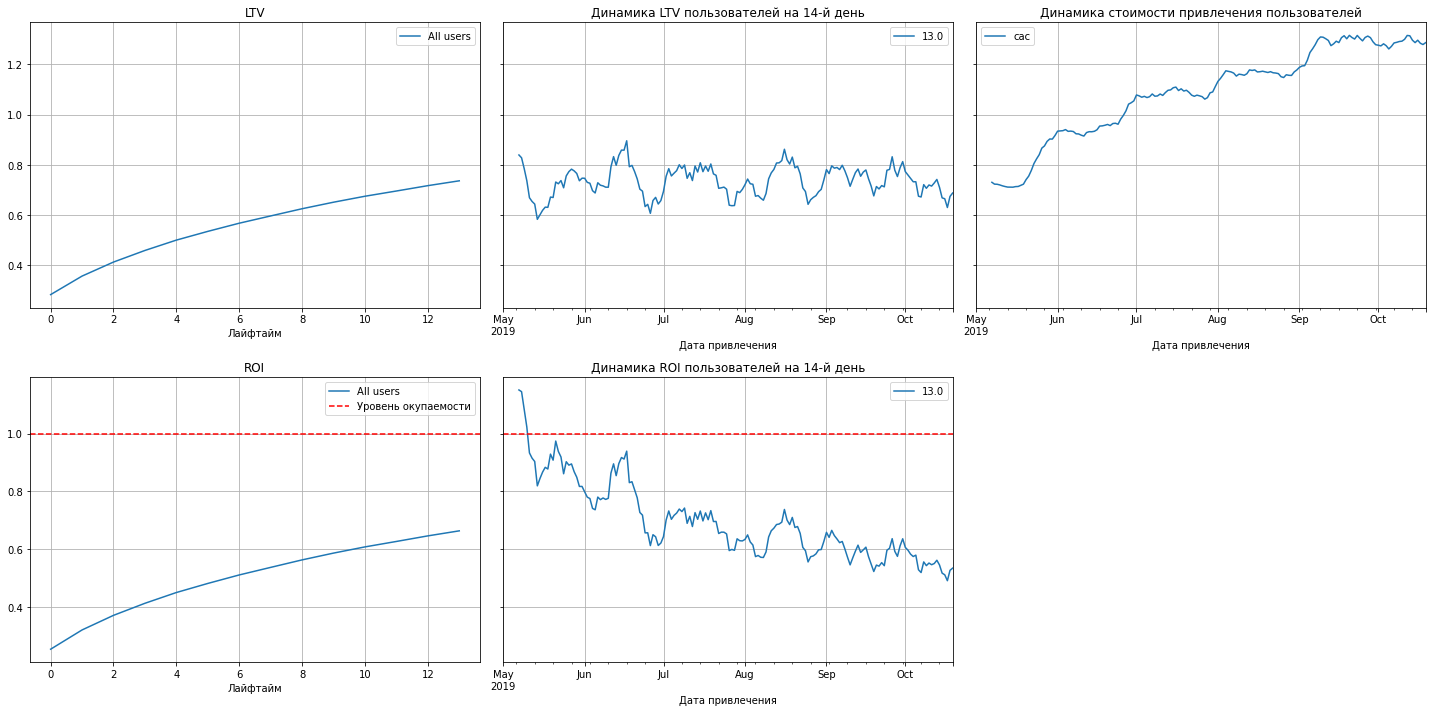

In [54]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

По графикам можно сделать такие выводы:
1. Реклама не окупается. ROI к концу второй недели около 75%
2. Стоимость привлечения пользователей с середины мая растет.
3. ROI c середины мая падает.
3. LTV в целом стабилен.

Чтобы разобраться в причинах, пройдём по всем доступным характеристикам пользователей — стране, источнику и устройству первого посещения.

### Проанализируйте окупаемость рекламы с разбивкой по устройствам

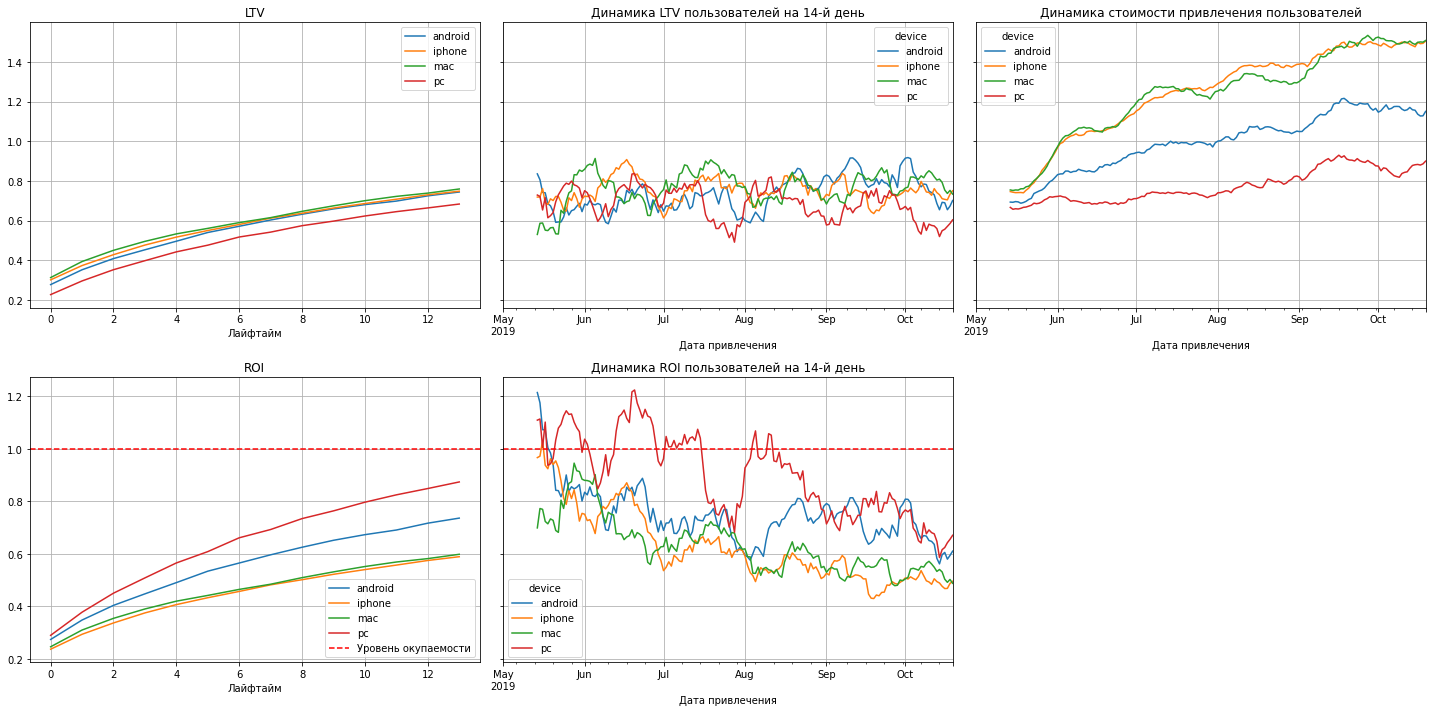

In [55]:
dimensions = ['device']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

1. Стоимость привлечения выше всего у айфона и mac, ниже всего у pc. 
2. У всех устройств стоимость привлечения растет.
3. У PC есть всплески окупаемости
4. ROI у всех ниже 100%, при этом у PC ROI выше всех.
#### Рассмотрим конверсию с разбивкой по устройствам

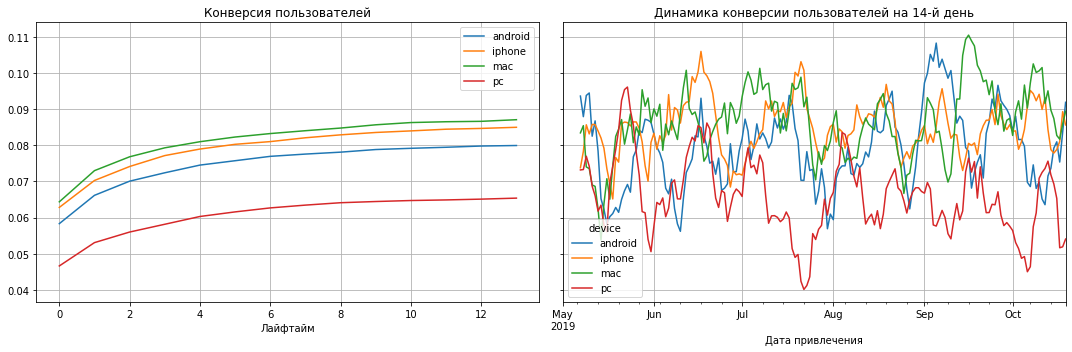

In [56]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Судя по графикам mac на первом месте и айфон на втором по конвертации. Хуже всех проявляет себя pc. 
#### Изучим удержание c разбивкой по устройствам:

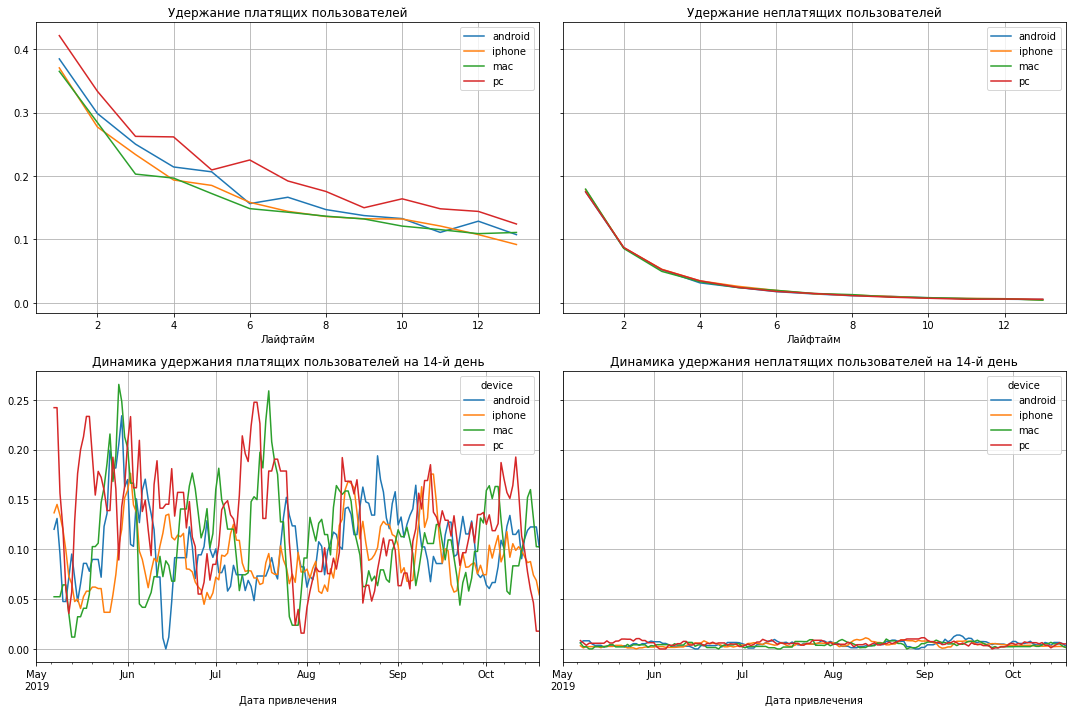

In [57]:
dimensions = ['device']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Лучше всего удержание у PC.

### Проанализируйте окупаемость рекламы с разбивкой по странам

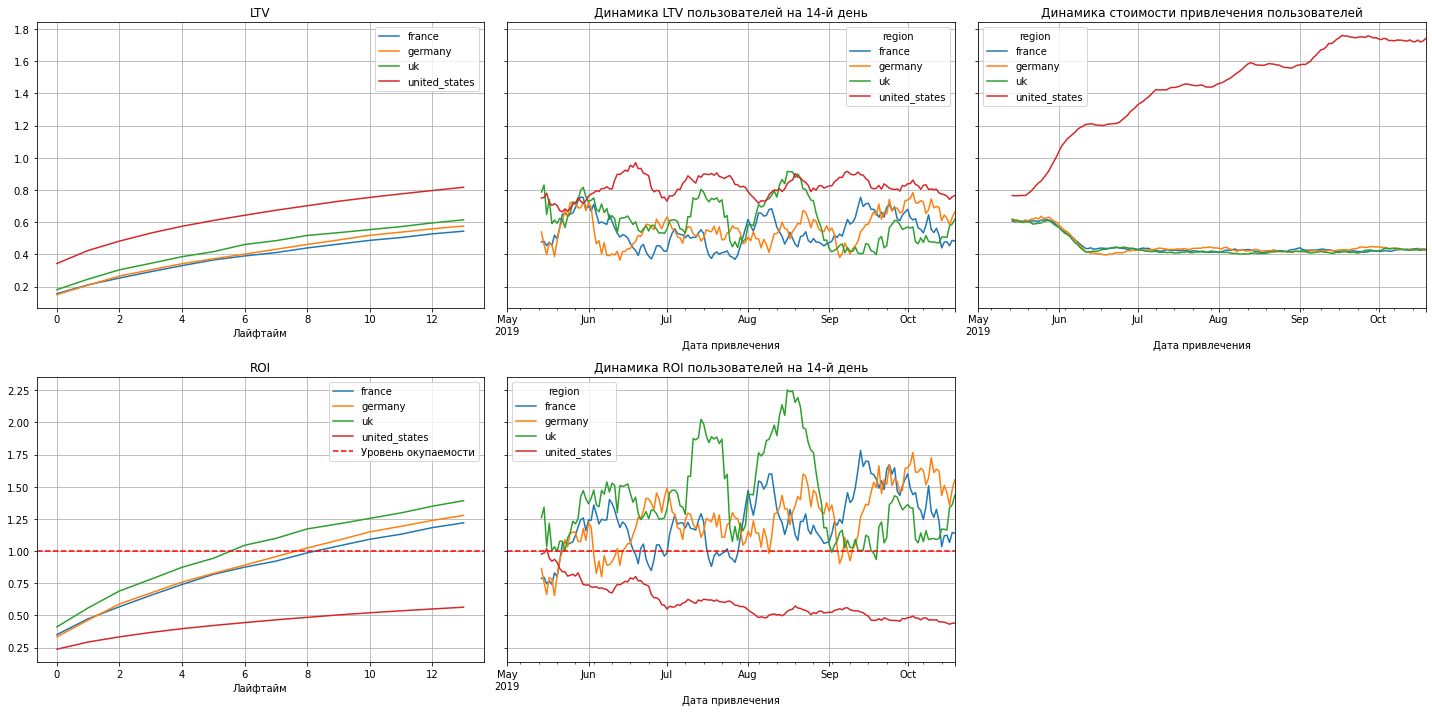

In [58]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

1. Клиенты приходят из Франции, Германии, Англии и США. Лучше всего окупается Англия, хуже всего-США. 
2. Окупаемость США начала падать с середины мая - вероятно тогда произошло какое-то событие, которое на это повлияло, например, неудачный релиз. 
3. В США стоимость рекламы с середины мая растет, в остальных странах остается неизменной.
4. LTV в целом стабилен.

Вероятно проблему нужно искать в США. 


#### Рассмотрим конверсию с разбивкой по странам

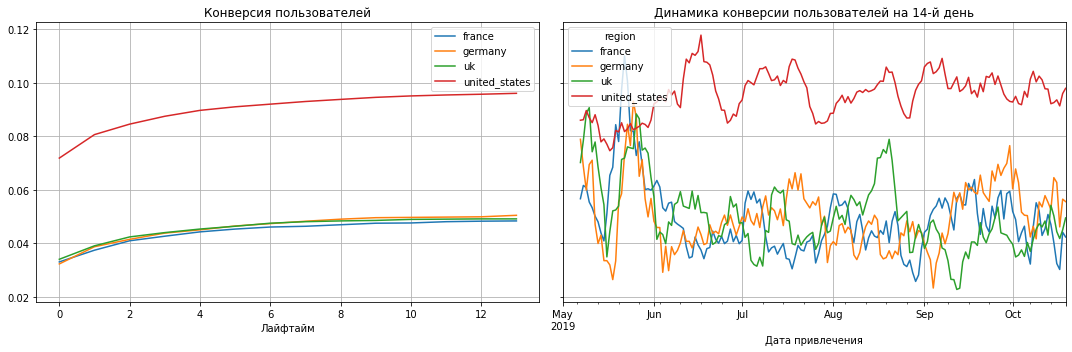

In [59]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Здесь США выделяется самой высокой конверсией, остальные страны ниже и примерно на одном уровне.

#### Изучим удержание с разбивкой по странам

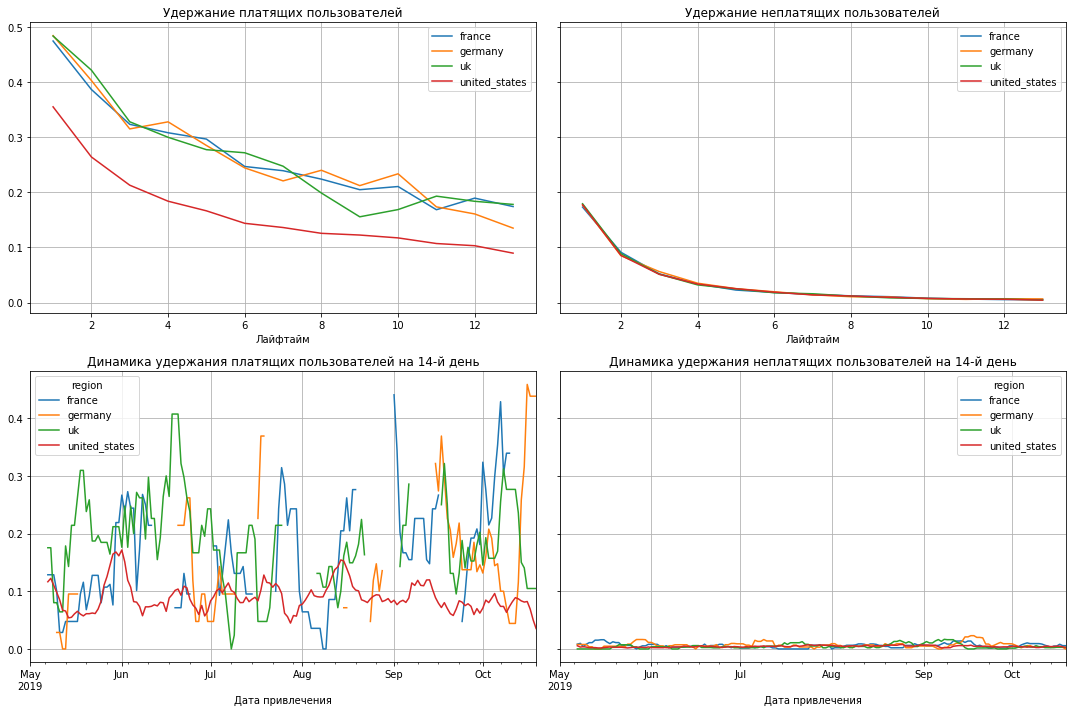

In [60]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Здесь США снова выделяется- при самой высокой конверсии, у пользователей США- самое плохое удержание. 

### Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам

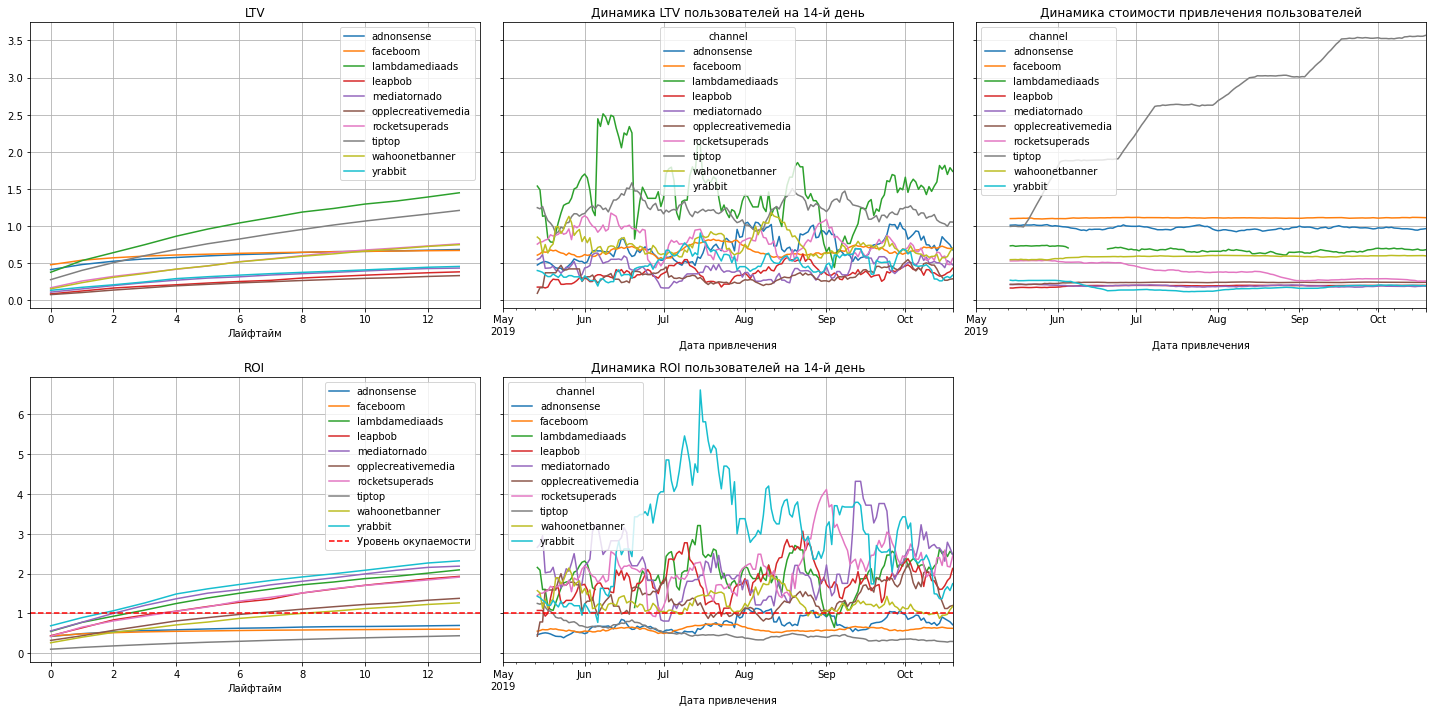

In [61]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

1. Самый высокий LTV у yarrabit
2. Лучше всего окупается yrabbit. 
3. Не окупаются каналы adnonsense, faceboom, tiptop (хуже всех).
4. Значительно растет стоимость привлечения из tiptop.
#### Рассмотрим конверсию с разбивкой по каналам

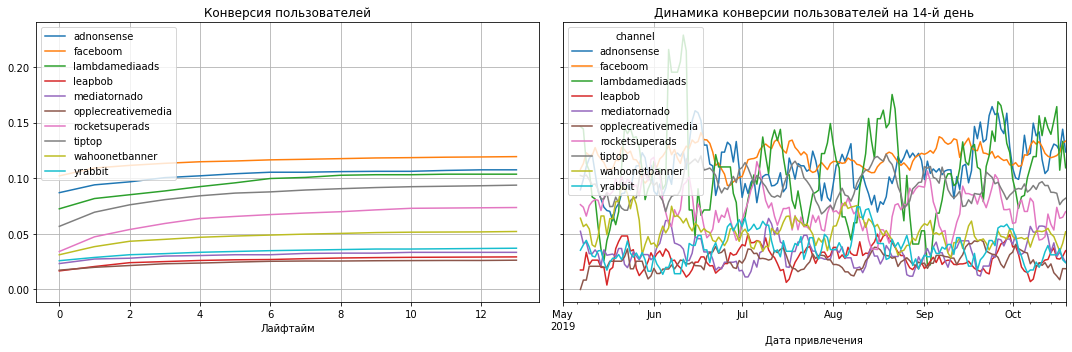

In [62]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Лучше всего конвертируется Fb, хуже всего leapbob, mediatornado. Один из плохоконвертирующихся каналов - yarabbit.

#### Изучим удержание с разбивкой по каналам

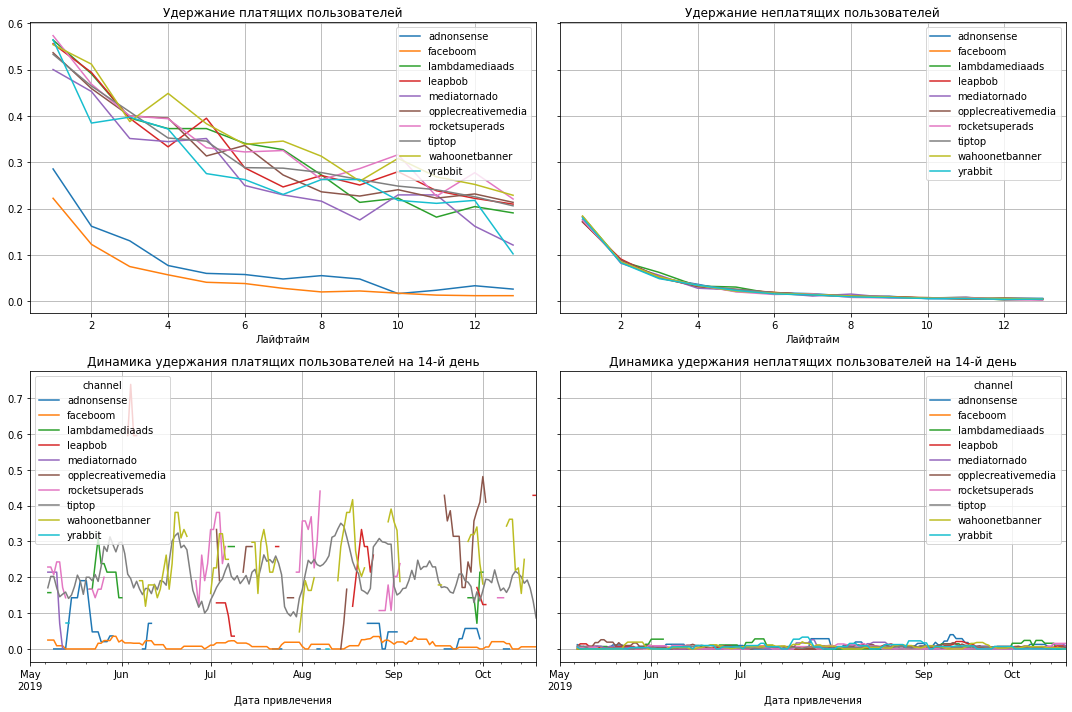

In [63]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Хуже всего удерживаются клиенты из ФБ и adnonsense.

# Шаг 6. Напишите выводы

Посетители приложения:
США - 66.7%
Англия - 11.7%
Франция - 11.6%
Германия 10.0%

Платящие пользователи:
США - 77.7%
Англия - 7.9% 
Франция - 7.5%
Германия - 6.9%

Доля платящих для каждой страны:
США - 6.9%
Англия - 4.1% 
Франция - 4.0%
Германия - 3.8%

Устройства посетителей приложения:
Айфон- 36.3%
Андроид- 23.4%
PC- 20.3%
Мак -20.0%

Устройства платящих пользователей:
Айфон- 38.1%
Андроид- 23.1%
Мак-20.3%
PC-20.0%

Доля платящих пользователей
Мак 6.4%
Айфон 6.2%
Андроид 5.9%
PC  5.0%

Рекламные каналы по пользователям:
organic - 37,6%,
faceboom - 19.4%
tiptop - 13%. 

Рекламные каналы по платящим пользователям:
faceboom - 40%  
tiptop 21.1%
organic 13.1%

Доля платящих пользователей - 
faceboom 12.2%
adnonsense 11.3%
lambdamediaads 10.5%


#### Причины неэффективности привлечения пользователей:

* tiptop - самый дорогой САС и продолжает стремительно расти, на него было потрачено 52% всего бюджета

* adnonsense, faceboom, tiptop - проблемы с удержанием 

* проблемы с рекламой в США - при хорошей конверсии-очень плохое удержание клиентов

* Стоимость привлечения пользователей с середины мая растет.

* ROI c середины мая падает.

* всплески окупаемости по устройствам есть только у PC

* У самых хорошо конвертирующихся устройств - мак, айфон, андроид - плохое удержание

* leapbob, mediatornado очень плохо конвертируются




 
#### Рекомендации для отдела маркетинга для повышения эффективности:

* Исключить траты на tiptop

* Проверить работу приложения на маках и айфонах

* Проверить корректность работы регистарции и покупки у пользователей, пришедших с faceboom особенно в США/ Если все работает корректно-отменить его.

* Увеличить траты на рекламу в lambdamediaad, rocketsuperads, wahoonetbanner

* Рассмотреть Англию как потенциальный рынок, куда можно больше вложиться в рекламу, так как там явно есть потенциал 